# Study of data reuse: Electrophysiological recordings of striatal low threshold-spiking interneuron (v1)


In this notebook we will look more closely at the EBRAINS dataset " Electrophysiological recordings of striatal low threshold-spiking interneuron", contributed by Sten Grillner from the Department of Department of Neuroscience, Karolinska Institutet, Stockholm.https://doi.org/10.25493/5GE0-6MF.

As we can see from the dataset description,

The study entails the collection of single cell patch-clamp recordings, done in conjunction with morphological reconstructions, from low threshold-spikinginterneurons in the striatum. More information is available in the Data Descriptor.

This dataset forms part of the results reported in Hjorth JJJ, Kozlov A, Carannante I, Frost Nylén J, Lindroos R, Johansson Y, Tokarska A, Dorst MC, Suryanarayana SM, Silberberg G, Hellgren Kotaleski J, Grillner S. The microcircuits of striatum in silico. Proc Natl Acad Sci U S A. 2020 Apr 28;117(17):9554-9565. https://doi.org/10.1073/pnas.2000671117

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article.


### Notes

Python version: 3.12.3\
Numpy version: \
Matplotlib:

### Downloading the data

Please note that this is a 1.7 GB dataset. Over a slow connection, this could take a long time to download. If running this notebook on a shared resource such as the EBRAINS lab, you may need to delete the downloaded data after use, to avoid taking up too much disk space.

To get the download link, we clicked on the link to the dataset card above, then clicked on "Get data" and right-clicked on "Download dataset".

In [ ]:
# imcomplete

import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".local"))

In [ ]:
import logging
import warnings
import zipfile

from fairgraph import KGClient
import fairgraph.openminds.core as omcore

omcore.set_error_handling(None)
warnings.filterwarnings('ignore')
logging.disable(sys.maxsize)

# To communicate with the EBRAINS Knowledge Graph, we use a KGClient object.
# If running this notebook in the EBRAINS Lab, we can get the authorization token from the Lab environment.
token = clb_oauth.get_token()
kg_client = KGClient(host="core.kg.ebrains.eu", token=token)

In [ ]:
dataset_version_doi = "10.25493/5GE0-6MF"

dataset_versions = omcore.DatasetVersion.list(
    kg_client, 
    digital_identifier__identifier=dataset_version_doi,
    follow_links={"repository": {"files": {}}},
    scope="any"
)

assert len(dataset_versions) == 1  # check: the DOI should be for a single, specific version of the dataset
dataset_version = dataset_versions[0]

# check we have the correct version of the dataset
assert dataset_version.full_name == "Electrophysiological recordings of striatal low threshold-spiking interneuron"
assert dataset_version.version_identifier == "v1"

if not os.path.exists("downloads"):  # only download the dataset if it hasn't been downloaded previously
    dataset_path = dataset_version.download("downloads", kg_client, accept_terms_of_use=True)[0]
else:
    dataset_path = "downloads/hbp-d000007_LTS-ephys_pub.zip"
with zipfile.ZipFile(dataset_path, "r") as z:
    z.extractall("downloads")

### Exploring and visualizing the data

The zip file contains 2 datasets: 2019Q3/lts and 2019Q3_NWB/lts. In the following analysis, We focus on the 2019Q3/lts dataset.

The dataset contains a number of files with two extensions: *.dat and *.pxp. Original single cell recordings can be find in the folder named original and pre-analazed recordings can be find in the folder named derived. For more information about the folder structure of the dataset see DATA REGISTRY in the Data Descriptor.

This dataset corresponds to the experimental results of the Figure 4 of Hjorth et al.2020. One cell is considered.
We know from the dataset metadata that these are electrophysiology data, and more specifically that they were obtained with the whole cell patch clamp technique in current clamp mode. For the other figures in the article, the authors provided jupyter notebooks allowing global visualization of the differents current clamp protocols and the relation between currents and membrane potential or frequencies. 
We will adapt these global analysis to this dataset.

First, let's read the first three files:

Thanks to the Data Descriptor, we know that the dataset contains two types of files corresponding to currents recording (channel 2) and membrane potential (voltage) recording (channel 3). The prefix can be find directly in the filename. The liquid_junction_potential estimated at 9.5mV has to be subtracted for the analysis. 

In [51]:
path = 'hbp-d000007_LTS-ephys_pub/2019Q3/lts/derived/Experiment-9862'
prefix = 'ECalllong'
channels = {'current': 2, 'voltage': 3}
liquid_junction_potential = 9.5

We will use the function "plot_traces" implemented by the authors to visualize the current and voltage traces. 

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plot_traces(path, prefix, protocol, channels, recordings,
                vshift=0, title=None, figsize=(12, 8)):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax1.set_ylabel('Voltage (mV)')
    ax2.set_ylabel('Current (pA)')
    ax2.set_xlabel('Time (ms)')
    if not title:
        title = protocol
    fig.suptitle(title)
    if len(recordings) > 1:
        color_cycle = [plt.cm.Blues(i) 
                       for i in np.linspace(0.3, 1, len(recordings))**2]
        ax1.set_prop_cycle('color', color_cycle)
        ax2.set_prop_cycle('color', color_cycle)
    for rec in reversed(recordings):
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        voltage = data[:, 1] - vshift
        ax1.plot(time, voltage)
        ax2.plot(time, current)
    return fig


In addition to path and prefix defined above, "plot_traces" function takes as arguments:
- protocol: indicated in the filename, in this case 'IV' 
- repetitions: correspond to the number indicated in the filename
- title: feature_protocol indicating the protocol vizualized, can be the string as protocol.

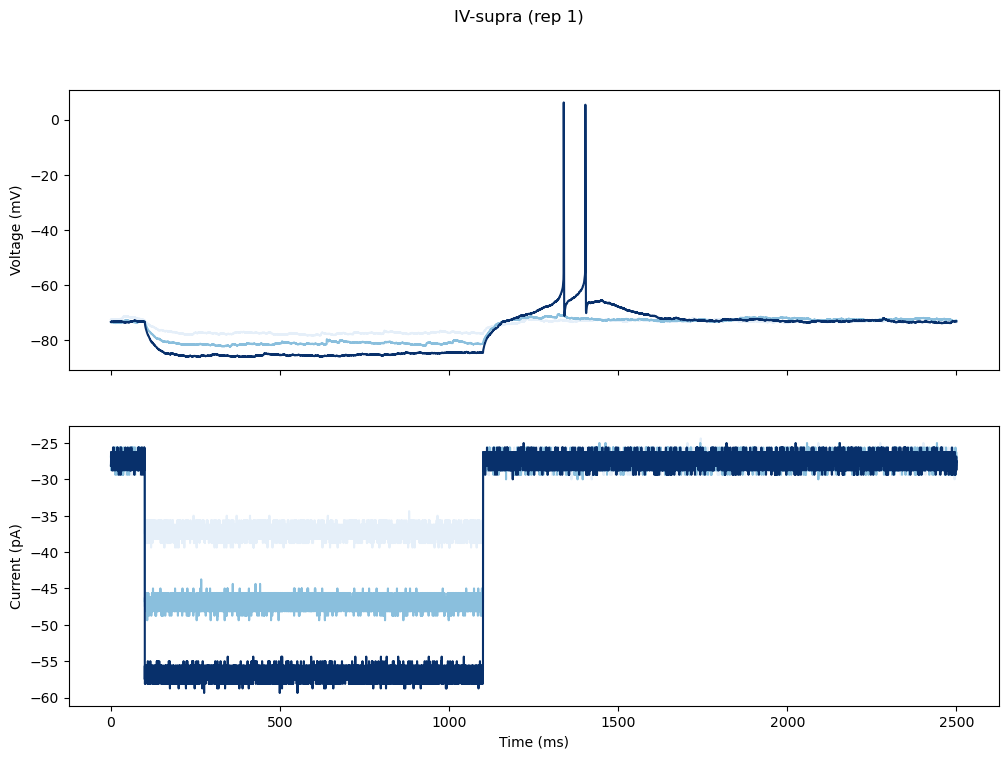

In [53]:
protocol = 'IV'
feature_protocol = 'IV-supra'
repetitions = [[657,658,659]]
vshift=liquid_junction_potential

for recordings in repetitions[0:1]:
    fig = plot_traces(path, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)

#### Figure 4B

- let's reproduced some article figure - start with the Figure 4B 
- Inspired by the plot_trace function 
- Identify the right traces graphically  
- First plot all the traces

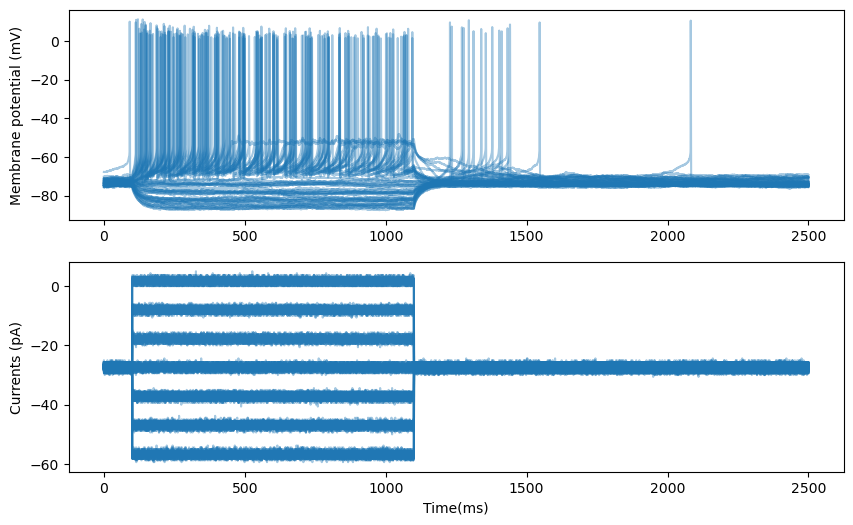

In [94]:
import os 

filename_list = os.listdir(path)
repetitions = list(np.unique([int(name.split('_')[-1].split('.')[0]) for name in filename_list])) # gets  the repetition number in filenames
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(10, 6))

for rec in repetitions:
    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    current = data[:, 1]

    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    voltage = data[:, 1] - vshift

    ax1.plot(time, voltage, color='tab:blue', alpha=0.4)
    ax2.plot(time, current, color='tab:blue', alpha=0.4)
    ax1.set_ylabel('Membrane potential (mV)')
    ax2.set_ylabel('Currents (pA)')
    ax2.set_xlabel('Time(ms)')


- To identfy which trace is used in the article it is possible to isolate each plot by using plt.show() in the loop. 

The files:
- ECalllong_IV_ch2_699.dat
- ECalllong_IV_ch2_700.dat
- ECalllong_IV_ch2_701.dat
- ECalllong_IV_ch2_701.dat


- ECalllong_IV_ch3_699.dat
- ECalllong_IV_ch3_700.dat
- ECalllong_IV_ch3_701.dat
- ECalllong_IV_ch2_716.dat



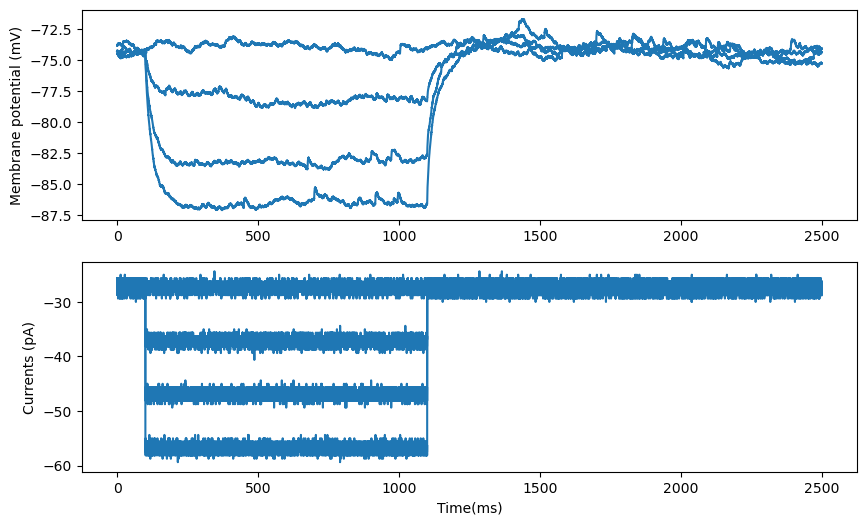

In [95]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(10, 6))

repetitions = [699,700,701,716]

for rec in repetitions:
    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    current = data[:, 1]
    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    voltage = data[:, 1] - vshift

    ax1.plot(time, voltage, color='tab:blue')
    ax2.plot(time, current, color='tab:blue')

    ax1.set_ylabel('Membrane potential (mV)')
    ax2.set_ylabel('Currents (pA)')
    ax2.set_xlabel('Time(ms)')


- FIGURE ARTICLE: What we want to reproduce 

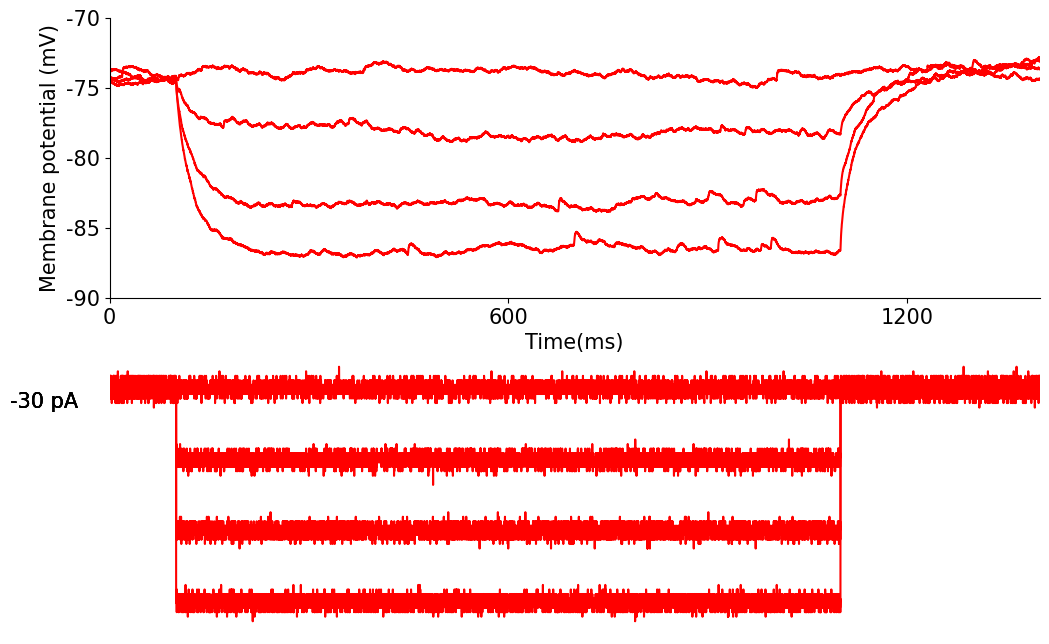

In [110]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(12, 8))

repetitions = [699,700,701,716]

for rec in repetitions:
    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    current = data[:, 1]
    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    voltage = data[:, 1] - vshift

    ax1.plot(time, voltage, color='r')
    ax2.plot(time, current, color='r')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim(-90,-70)
    ax1.set_xlim(0,1400)
    ax1.set_xticks([0, 600, 1200])
    ax1.set_xticklabels(['0', '600', '1200'], size = 15)
    ax1.set_yticks([-70, -75, -80, -85, -90])
    ax1.set_yticklabels(['-70', '-75', '-80', '-85', '-90'], size = 15)
    ax1.set_xlabel('Time(ms)', size = 15, loc='center')
    ax1.set_ylabel('Membrane potential (mV)', size = 15)


    ax2.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.text(-150, -30, r'-30 pA', size = 15) 
    ax2.set_xlim(0,1400)

plt.show()

#### Figure 4C

- Figure C: membrane potential as a function of function of currents 
- First we Identify the exact value of the currents
- recording window is 2.5s. However the stimulation duration is 1 s. We have to consider that and focus only on the stimulation duration by selecting the data corresponding to this second.  

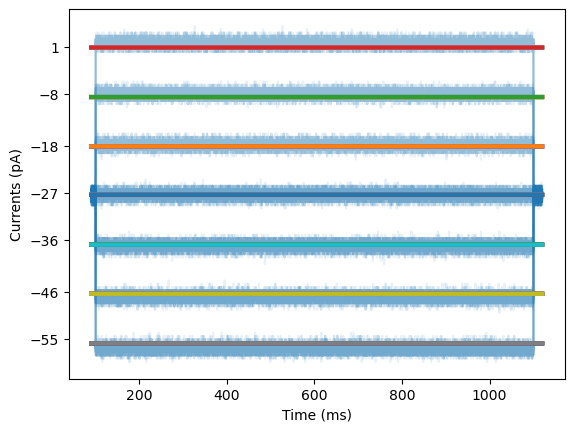

In [179]:
from math import ceil

repetitions = list(np.unique([int(name.split('_')[-1].split('.')[0]) for name in filename_list]))
l1 = []
l1_current_value = []

for rec in repetitions:
    fullname = path + '/' + prefix + '_' + protocol\
    + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0][900:11200]
    current = data[:, 1][900:11200]
    
    mean_x = time
    mean_y = [np.mean(current)] * len(time)
    mean_ceil = ceil(mean_y[0])
    l1.append(mean_ceil)
    l1_current_value = list(np.unique(l1))

    plt.plot(time,current, 'tab:blue', alpha=0.1, zorder = 1)
    plt.plot(mean_x,mean_y, linewidth = 3, zorder = 2)
    plt.yticks(l1_current_value)
    plt.xlabel('Time (ms)')
    plt.ylabel('Currents (pA)')



-  From there: We want to obtain the corresponding voltage. The current are: -55, -46, -36, -27, -18, -8, 1 
-  Extrcat the correspondoing current.

In [183]:
VI = {}
for index in range(0,len(np.unique(l1_current_value))):
    VI[f'{index}'] =[]

for rec in repetitions:
    for index in range(0,len(l1_current_value)):
        fullname_current = path + '/' + prefix + '_' + protocol\
        + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        fullname_voltage = path + '/' + prefix + '_' + protocol\
        + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'

        data_current = np.loadtxt(fullname_current)
        time = data_current[:, 0][900:11200]
        current = data_current[:, 1][900:11200]
        
        data_voltage = np.loadtxt(fullname_voltage)
        voltage = data_voltage[:, 1][900:11200]- liquid_junction_potential

        mean = np.mean(current)
        mean_ceil = ceil(mean)
        if mean_ceil == l1_current_value[index]:
            VI[f'{index}'].append(voltage)


-  Organisation in a dictionary. Keys corresponds to the current indice in the list.Values are a list of voltage values/ membrane potential for each voltage trace/ files that corresponds to the current values. 

In [292]:
values_VI = {}
for keys in VI.keys():
    values_VI[f'{keys}'] =[]

    for k in range(0,len(VI[keys])):
        values_VI[f'{keys}'].append(VI[keys][k])

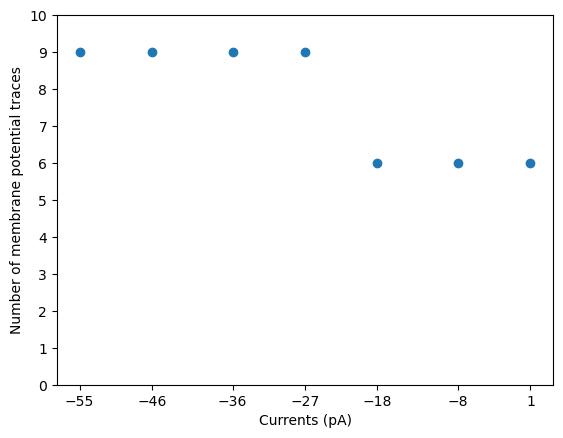

In [309]:
for i in range(0,len(l1_current_value)):
    plt.scatter(l1_current_value[i], len(values_VI[str(i)]), color='tab:blue')
    plt.ylim(0,10)
    plt.xticks(l1_current_value)
    plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    plt.xlabel('Currents (pA)')
    plt.ylabel('Number of membrane potential traces')



- For each current: 1. calculate the mean of the value of all traces. | 2. calculate the mean of the value of each traces
- Plot : the mean values of each traces for each currents 

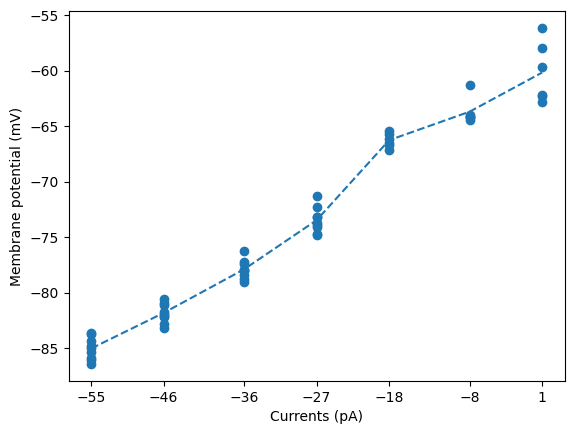

In [259]:
voltage_list = []
current_list = []
l1_mean_voltage = []

for key in values_VI:
    mean_voltage =  np.mean(values_VI[key])
    l1_mean_voltage.append(mean_voltage)

    for index in range(0,len(values_VI[key])):
        
        voltage_list.append(np.mean(values_VI[key][index]))
        current_list.append((l1_current_value)[int(key)])

plt.figure()
plt.scatter(current_list,voltage_list)
plt.plot(l1_current_value,l1_mean_voltage, '--', color = 'tab:blue')
plt.xlabel('Currents (pA)')
plt.ylabel('Membrane potential (mV)')
plt.xticks(l1_current_value)
plt.show()


- We consider only the currents of the figure 

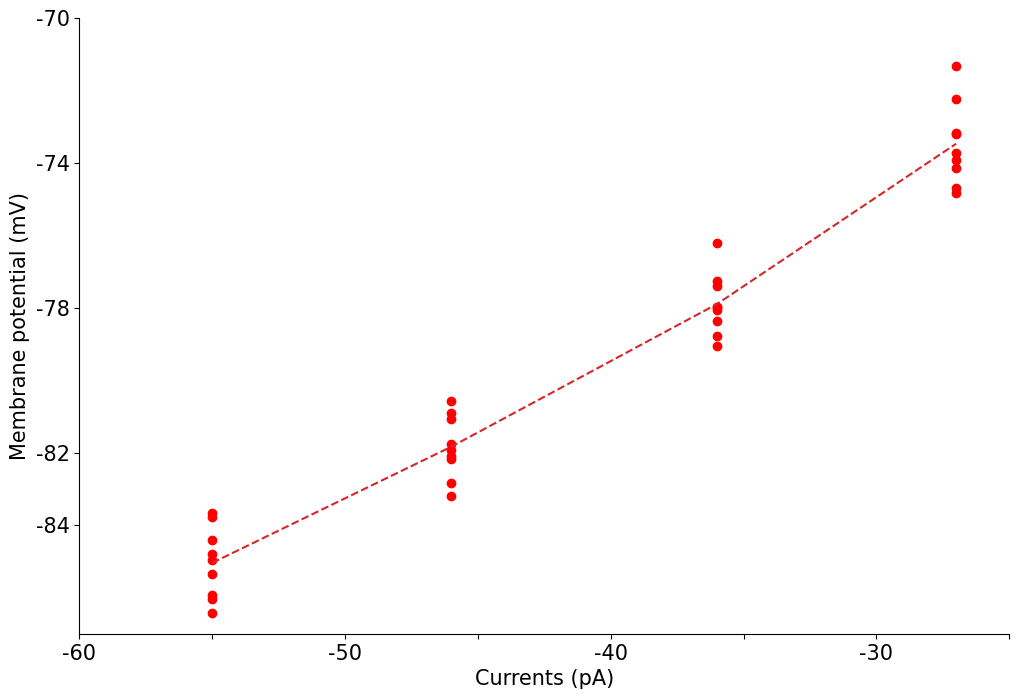

In [283]:
plt.figure(figsize=(12, 8))
plt.scatter(current_list[:36],voltage_list[:36], color ='r')
plt.plot(l1_current_value[0:4],l1_mean_voltage[0:4], '--', color = 'tab:red')
plt.xlabel('Currents (pA)', size = 15)
plt.ylabel('Membrane potential (mV)', size = 15)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_yticks([-84, -82, -78, -74, -70])
plt.gca().set_yticklabels(['-84', '-82', '-78', '-74', '-70'], size = 15)
plt.gca().set_xticks([-60, -55, -50, -45, -40, -35, -30, -25])
plt.gca().set_xticklabels(['-60', '', '-50', '', '-40', '', '-30', ''], size = 15)
plt.ylim(-87,-70)
plt.xlim(-60,-25)

plt.show()

#### Figure 4D

- Figure 4D is the same processus as the Figure 4B 
- File ... 717. Determined graphically 

Text(0.5, 0, 'Time(ms)')

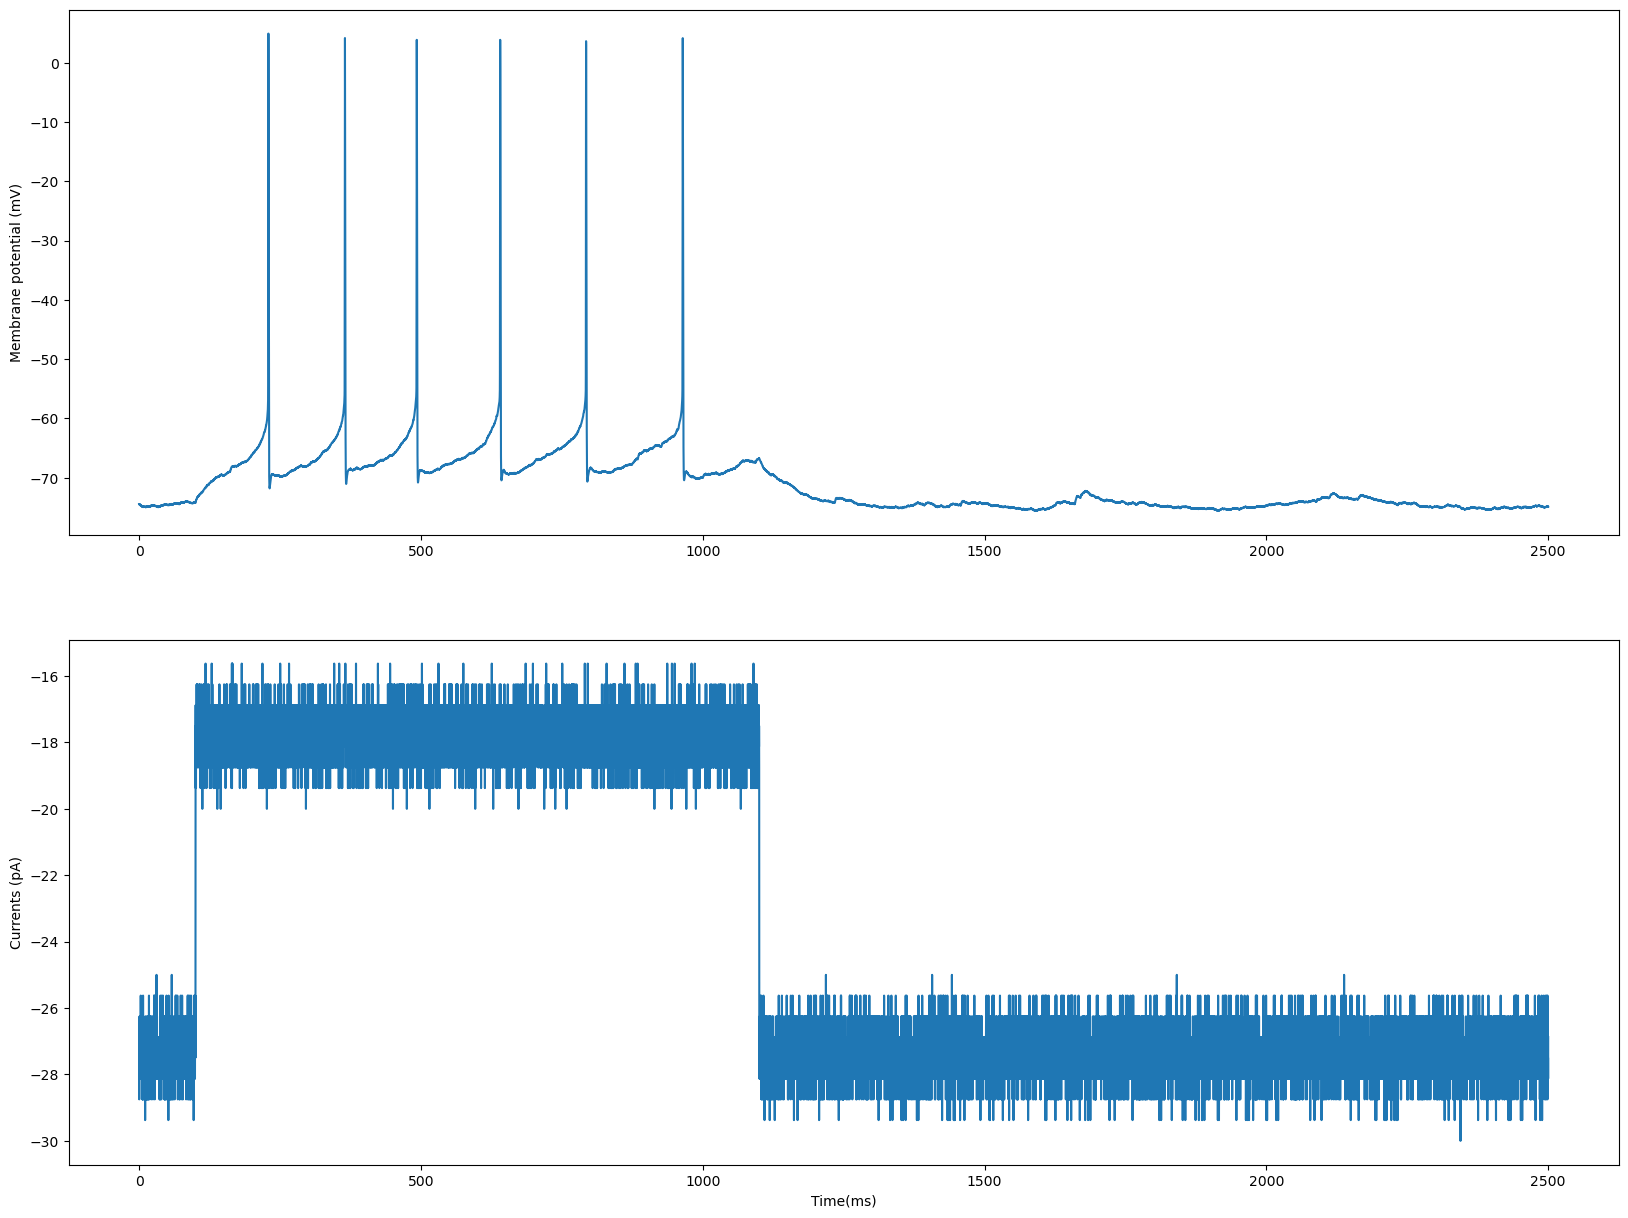

In [286]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(20, 15))

recordings = [717]

fullname = path + '/' + prefix + '_' + protocol \
    + '_ch' + str(channels['current']) + '_' + str(recordings[0]) + '.dat'
data = np.loadtxt(fullname)
time = data[:, 0]
current = data[:, 1]
fullname = path + '/' + prefix + '_' + protocol \
    + '_ch' + str(channels['voltage']) + '_' + str(recordings[0]) + '.dat'
data = np.loadtxt(fullname)
voltage = data[:, 1] - vshift

ax1.plot(time, voltage, color='tab:blue')
ax2.plot(time, current, color='tab:blue')

ax1.set_ylabel('Membrane potential (mV)')
ax2.set_ylabel('Currents (pA)')
ax2.set_xlabel('Time(ms)')


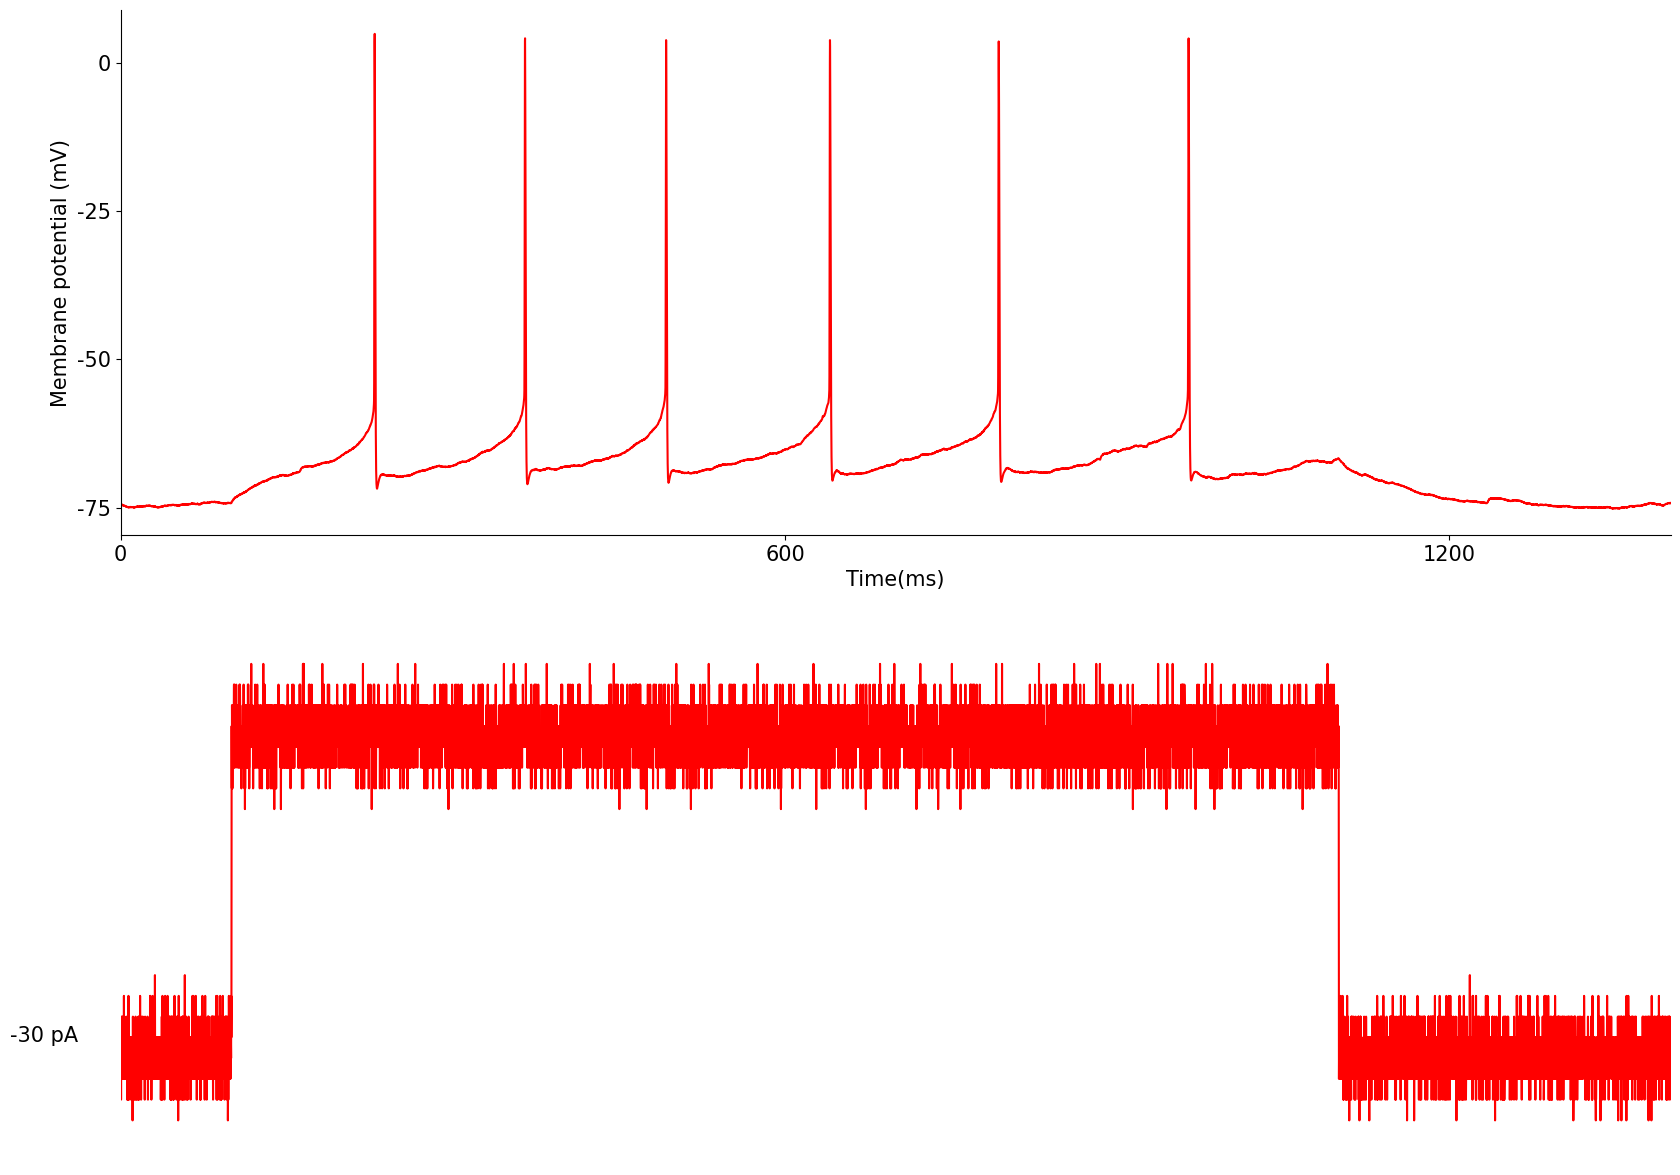

In [289]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

recordings = [717]

for rec in recordings:
    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    current = data[:, 1]
    fullname = path + '/' + prefix + '_' + protocol \
        + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    voltage = data[:, 1] - vshift

    ax1.plot(time, voltage, color='r')
    ax2.plot(time, current, color='r')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim(0,1400)
    ax1.set_xticks([0, 600, 1200])
    ax1.set_xticklabels(['0', '600', '1200'], size = 15)
    ax1.set_yticks([0, -25, -50,-75])
    ax1.set_yticklabels(['0', '-25', '-50', '-75'], size = 15)
    ax1.set_xlabel('Time(ms)',size = 15)
    ax1.set_ylabel('Membrane potential (mV)',size = 15)



    ax2.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(0,1400)

    ax2.text(-100, -27, r'-30 pA', size = 15) 

plt.show()

### Summary